In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load the dataset
data = pd.read_csv('data/Duke Roster and Performance Data - v2.csv')

print(data)

print(data.dtypes)

    Year School      Coach  numGames  numWins  numLosses  overallPct  \
0   2023   Duke       Elko        13        8          5    0.615385   
1   2022   Duke       Elko        13        9          4    0.692308   
2   2021   Duke  Cutcliffe        12        3          9    0.250000   
3   2020   Duke  Cutcliffe        11        2          9    0.181818   
4   2019   Duke  Cutcliffe        12        5          7    0.416667   
5   2018   Duke  Cutcliffe        13        8          5    0.615385   
6   2017   Duke  Cutcliffe        13        7          6    0.538462   
7   2016   Duke  Cutcliffe        12        4          8    0.333333   
8   2015   Duke  Cutcliffe        13        8          5    0.615385   
9   2014   Duke  Cutcliffe        13        9          4    0.692308   
10  2013   Duke  Cutcliffe        14       10          4    0.714286   
11  2012   Duke  Cutcliffe        13        6          7    0.461538   
12  2011   Duke  Cutcliffe        12        3          9    0.25

In [78]:
# Columns that are irrelevant and that are directly used to calculate win%
#exclude_columns = ['School', 'Coach', 'numGames', 'numWins', 'numLosses', 'confPct', 'homePct', 'roadPct', 'neutralPct', 'bowlGame', 'Time of Possession_Value']

# Only include these columns
include_columns = ['overallPct', 'FPI_rank','SOS_rank','numPositions','numC','numCB','numDB','numDE','numDL','numDT','numK','numLB','numLS',
                   'numOG','numOL','numOT','numP','numQB','numRB','numS','numTE','numWR','numOffense','numDefense','numFreshmen','numSophomores','numJuniors','numSeniors',
                   'numPlayers','class_natlRank','class_confRank','class_score',
                   'avgHeight', 'avgWeight', 'transfer_natlRank','transfer_score','numGrad','numRedshirtFreshmen','numRedshirtSophomores','numRedshirtJuniors','numRedshirtSeniors','numRedshirting']
#include_columns = [col for col in data.columns if col not in exclude_columns]

# Select relevant columns
refined_data = data[include_columns]

# Handle missing values using imputation
imputer = SimpleImputer(strategy='mean')
refined_data = pd.DataFrame(imputer.fit_transform(refined_data), columns=refined_data.columns)

# Define features and target
y = refined_data['overallPct']
X = refined_data.drop('overallPct', axis=1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Mean Absolute Error: 0.11820967399999843
Mean Squared Error: 0.014408337865102462
R² Score: -1.0505184374671934


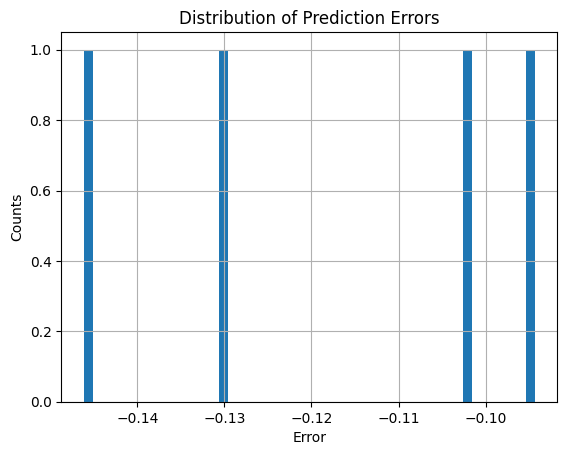


Importance of each feature used in the model:
FPI_rank: 0.4430118682589688
numRedshirtJuniors: 0.11768730837755563
numRedshirtSeniors: 0.08062130053066914
SOS_rank: 0.03529720604133551
numDT: 0.03072409006300199
numJuniors: 0.02539497932364265
avgHeight: 0.0178581448575165
numDE: 0.016606054288914412
numLB: 0.015991454458022178
numRedshirtSophomores: 0.015683901327326166
numSeniors: 0.015619170680566046
avgWeight: 0.015255197111560696
numPlayers: 0.01369836075002841
class_score: 0.013561294964975264
class_natlRank: 0.01319871062315696
numSophomores: 0.01129459134977275
numPositions: 0.01087831654011954
numOL: 0.010592545885140846
numOG: 0.010040782085735106
numQB: 0.009536119606721356
numTE: 0.008801915807857491
numDefense: 0.008628368144427936
numCB: 0.00843029378899763
numOffense: 0.00841995697692599
numRB: 0.006799558360959124
numK: 0.005871205845013176
class_confRank: 0.005679966254021087
numFreshmen: 0.005055223005507638
numS: 0.004802065040385647
numRedshirtFreshmen: 0.004021076

In [75]:
# Create a Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(bootstrap=True, n_estimators=1000, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

results = y_pred - y_test
unique, counts = np.unique(results, return_counts=True)

# Plot residuals
fig = plt.figure(num=1, clear=True)
ax = fig.add_subplot(1, 1, 1)
ax.hist(results, bins=50)
ax.set(xlabel='Error', ylabel='Counts',
       title='Distribution of Prediction Errors')
ax.grid(True)
plt.show()

# Feature Importances
print("\nImportance of each feature used in the model:")
feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
for idx in sorted_indices:
    print(f"{X.columns[idx]}: {feature_importances[idx]}")

# Correlation matrix of the dataframe
print("\n\nCorrelation matrix of the dataframe, showing the Pearson correlation coefficients between each pair of features:")
correlation_matrix = refined_data.corr()
target_correlation = correlation_matrix['overallPct'].abs().sort_values(ascending=False)
print(target_correlation)

# Features ranked via RFE
from sklearn.feature_selection import RFE
rfe = RFE(model, n_features_to_select=1)
rfe.fit(X_train, y_train)
ranked_features = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), X.columns))
print("\n\nFeatures ranked via RFE:")
print(ranked_features)

# Features ranked via ANOVA F-value
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_train, y_train)
ranked_features = sorted(zip(map(lambda x: round(x, 4), selector.scores_), X.columns))
print("\n\nFeatures ranked via ANOVA F-value:")
print(ranked_features)

In [76]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define a pipeline including standardization, PCA, and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Retain 95% of the variance
    ('model', RandomForestRegressor(bootstrap=True, n_estimators=1000, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# Feature Importances
print("\nImportance of each feature used in the model:")
pca = pipeline.named_steps['pca']
important_features = [X.columns[i] for i in pca.components_.argsort()[0][::-1]]
for feature in important_features:
    print(feature)


Mean Absolute Error: 0.20565854999999966
Mean Squared Error: 0.056666038692047796
R² Score: -7.064410912913242

Importance of each feature used in the model:
numRedshirtSophomores
numOffense
numRedshirtJuniors
numS
numRB
numPlayers
class_score
numDE
numDefense
numRedshirtSeniors
numLS
numWR
SOS_rank
numQB
numOG
numTE
transfer_natlRank
numGrad
numC
numOT
numDT
numP
numCB
numRedshirtFreshmen
numDB
numRedshirting
numFreshmen
numDL
avgHeight
avgWeight
numOL
numK
class_confRank
transfer_score
FPI_rank
numSophomores
class_natlRank
numSeniors
numPositions
numJuniors
numLB


In [77]:
from sklearn.preprocessing import PolynomialFeatures

# Define the degree of polynomial features
degree = 2  # You can adjust this value as needed

# Initialize PolynomialFeatures transformer
poly = PolynomialFeatures(degree=degree, include_bias=False)

# Fit and transform the training features
X_train_poly = poly.fit_transform(X_train)

# Transform the test features (without fitting again to prevent data leakage)
X_test_poly = poly.transform(X_test)

# Create a model (for example, RandomForestRegressor)
model = RandomForestRegressor(bootstrap=True, n_estimators=1000, random_state=42)

# Train the model using the polynomial features
model.fit(X_train_poly, y_train)

# Predict on the test set using polynomial features
y_pred = model.predict(X_test_poly)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


Mean Absolute Error: 0.16476186074999902
Mean Squared Error: 0.03177396185522728
R² Score: -3.521902194792788


In [84]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# Include these columns for testing
include_columns = ['overallPct', 'FPI_rank','SOS_rank','numPositions','numC','numCB','numDB','numDE','numDL','numDT','numK','numLB','numLS',
                   'numOG','numOL','numOT','numP','numQB','numRB','numS','numTE','numWR','numOffense','numDefense','numFreshmen','numSophomores','numJuniors','numSeniors',
                   'numPlayers','class_natlRank','class_confRank','class_score',
                   'avgHeight', 'avgWeight', 'transfer_natlRank','transfer_score','numGrad','numRedshirtFreshmen','numRedshirtSophomores','numRedshirtJuniors','numRedshirtSeniors','numRedshirting']
#include_columns = [col for col in data.columns if col not in exclude_columns]
refined_data = data[include_columns]

# Handle missing values using imputation
imputer = SimpleImputer(strategy='mean')
refined_data = pd.DataFrame(imputer.fit_transform(refined_data), columns=refined_data.columns)

# Define features and target
y = refined_data['overallPct']
X = refined_data.drop('overallPct', axis=1)

# Generate polynomial and interaction terms
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X)

# Compute exponential and logarithmic transformations
X_exp = np.exp(X)
X_log = np.log1p(X)  # Log transformation to handle zero and negative values

# Combine features
X_combined = np.concatenate([X, X_poly, X_exp, X_log], axis=1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Initialize RandomForestRegressor
model = RandomForestRegressor(n_estimators=1000, random_state=42)

# Initialize ExhaustiveFeatureSelector
efs = ExhaustiveFeatureSelector(model, min_features=1, max_features=len(X.columns), scoring='neg_mean_squared_error', cv=5)

# Fit EFS
efs = efs.fit(X_train, y_train)

# Get selected feature indices
selected_feature_indices = efs.best_idx_

# Select features
X_train_selected = X_train.iloc[:, selected_feature_indices]
X_test_selected = X_test.iloc[:, selected_feature_indices]

# Train the model
model.fit(X_train_selected, y_train)

# Predict on the test set
y_pred = model.predict(X_test_selected)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# Get selected feature indices
selected_feature_indices = efs.best_idx_

# Select features
selected_features = X.columns[selected_feature_indices]

# Print selected features
print("Selected Features:")
for feature in selected_features:
    print(feature)


C:\Users\Calvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Calvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Calvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Calvin\AppData\Local\Packages\PythonSoftwar